Train a multilayer perceptron on the MNIST dataset. Compare a “vanilla” model with a model using drop-out. Visualize the learning curves.
[Running model 10pts, model selection 5pts, dropout 5pts, BN 5pts, learning curve 5pts]


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout
from keras import backend as K

Using TensorFlow backend.


In [4]:
# load data
from keras.datasets import mnist

In [8]:
def mnist_data_split():
    r"""return processed train and test data,
    the actual process takes place here includes:
    1. reshape to nofrows, 28, 28, 1
    2. shuffle
    3. dummify labels
    """
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # input image dimensions
    img_rows, img_cols = 28, 28
    num_classes = 10
    # the data, shuffled and split between train and test sets
    
    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    
    y_train = y_train.astype('int32')
    y_test = y_test.astype('int32')
    
    print("after process: X train shape: {}, X test shape: {}, y train shape: {}, y test shape: {}".format(x_train.shape, x_test.shape, y_train.shape, y_test.shape))
    return  x_train, x_test, y_train, y_test

In [9]:
x_train, x_test, y_train, y_test = mnist_data_split()

x_train shape: (60000, 784)
60000 train samples
10000 test samples
after process: X train shape: (60000, 784), X test shape: (10000, 784), y train shape: (60000, 10), y test shape: (10000, 10)


In [10]:
print ("inputshape is : {}".format(x_train.shape[1]))

inputshape is : 784


### the vanila baseline has test accuracy 0.9657

In [11]:
def train_mnist_nnet_baseline( x_train, x_test, y_train, y_test):
    r"""
    Returns
    -------
    hisotry_callback : <class 'keras.callbacks.History'>
        used for retrospective examiniation
    """
    
    num_class = 10
    epochs = 32
    batch_size = 128
    input_shape = (784, ) #(784, )
    model = Sequential()
    model.add(Dense(32, input_shape=input_shape, activation="relu"))
    model.add(Dense(16, activation="relu"))
    model.add(Dense(num_class, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=['accuracy'])
    
    history_callback = model.fit(
                  x_train, 
                  y_train, 
                  verbose=0, 
                  batch_size=batch_size,
                  validation_data=(x_test, y_test),
                  epochs=epochs
              )
    
    score = model.evaluate(x_test, y_test, verbose=0)
    
    print("Test loss: {}".format(score[0]))
    print("Test accuracy: {}".format(score[1]))
    #print(model.summary())

    return history_callback

In [12]:
%time callback = train_mnist_nnet_baseline(x_train, x_test, y_train, y_test)

Test loss: 0.15051891407675574
Test accuracy: 0.9641000032424927
Wall time: 50.5 s


In [16]:
def plot_history(logger):

    df = pd.DataFrame(logger)
    #print(df)
    plt.figure(figsize=(16,9))
    df[['accuracy', 'val_accuracy']].plot()
    plt.ylabel("accuracy")
    plt.ylabel("loss")

### learning curve of the baseline single model

<Figure size 1152x648 with 0 Axes>

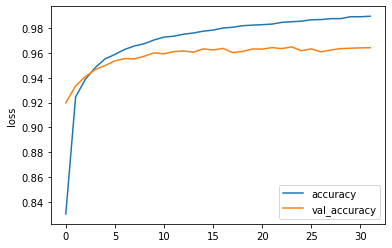

In [17]:
%matplotlib inline
plot_history(callback.history)

### Model selection using grid search (without dropout)

the best combination of parameters for a network without dropout are:  
    1. 64 epoches  
    2. first hidden layer with size 64, second hidden layer with size 32  
    3. with batch size fixed with 128  
achieves 0.971 test score

In [18]:
def make_mnist_nnet(hidden_size=16):
    r"""
    Returns
    -------
    model : model itself
    """
    
    num_class = 10
    input_shape = (784, ) #(784, )
    model = Sequential()
    model.add(Dense(hidden_size, input_shape=input_shape, activation="relu"))
    model.add(Dense(int(hidden_size/2), activation="relu"))
    model.add(Dense(num_class, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", 
                  optimizer="adam", 
                  metrics=['accuracy'])


    return model

In [ ]:
# calculated in by the script on GPU
clf = KerasClassifier(make_mnist_nnet)
param_grid = {'epochs': [12, 32, 64], 'hidden_size': [32, 64], 'batch_size':[128]}
grid = GridSearchCV(clf, param_grid=param_grid, cv=5)
grid.fit(x_train, y_train.astype('int32'))

Epoch 1/12
48000/48000 [==============================] - 1s 28us/step - loss: 0.6529 - accuracy: 0.7935
Epoch 2/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.2655 - accuracy: 0.9233
Epoch 3/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.2232 - accuracy: 0.9360
Epoch 4/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.1930 - accuracy: 0.9449
Epoch 5/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.1718 - accuracy: 0.9506
Epoch 6/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.1541 - accuracy: 0.9558
Epoch 7/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.1412 - accuracy: 0.9591
Epoch 8/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.1294 - accuracy: 0.9620
Epoch 9/12
48000/48000 [==============================] - 1s 27us/step - loss: 0.1209 - accuracy: 0.9640
Epoch 10/12
48000/48000 [==============================

In [ ]:
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline
res = pd.DataFrame(grid.cv_results_)
res.pivot_table(index=["param_epochs", "hidden_size"],
                values=['mean_train_score', "mean_test_score"])

In [ ]:
print ("mean test score: {} ".format(grid.cv_results_['mean_test_score']))

In [ ]:
print ("mean train score: {} ".format(grid.cv_results_['mean_train_score']))

mean test score: [ 0.95998333  0.9682      0.96158333  0.97016667  0.95916667  0.97126667] 


mean train score: [ 0.9782125   0.9906625   0.99300833  0.99909583  0.99725833  0.99918333] 

best params: {'epochs': 64, 'hidden_size': 64, 'batch_size': 128}